In [21]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
#import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

plt.style.use('seaborn-darkgrid')

In [22]:
psePupil = pd.read_csv('COVID_PSchExpPupil.csv',index_col = 0)
psePupil

,State,cases,deaths,Public School Expenditure 2016(Thousands),Student Enrollment,School Expenditures per Student Enrollment(Percent)
0,Alabama,387786,14345,6885677.0,743789.0,9257.567670
1,Alaska,18316,367,2319662.0,132477.0,17509.922477
2,Arizona,426614,18857,8551673.0,1109040.0,7710.878778
3,Arkansas,161569,3301,4872214.0,492132.0,9900.217828
4,California,2664110,102387,72003129.0,6305347.0,11419.376126
5,Colorado,766512,37828,8648369.0,899112.0,9618.789428
6,Connecticut,1314995,104185,10551327.0,537933.0,19614.574678
7,Delaware,234327,7813,1941408.0,134847.0,14397.116732
8,District of Columbia,229466,10822,1775833.0,84024.0,21134.830525
9,Florida,1726811,63147,25621239.0,2792234.0,9175.892493


In [8]:
psePupil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   State                                                51 non-null     object 
 1   cases                                                51 non-null     int64  
 2   deaths                                               51 non-null     int64  
 3   Public School Expenditure 2016(Thousands)            51 non-null     float64
 4   Student Enrollment                                   51 non-null     float64
 5   School Expenditures per Student Enrollment(Percent)  51 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ KB


In [9]:
psePupil.isnull().sum()

State                                                  0
cases                                                  0
deaths                                                 0
Public School Expenditure 2016(Thousands)              0
Student Enrollment                                     0
School Expenditures per Student Enrollment(Percent)    0
dtype: int64

In [10]:
psePupil.count()

State                                                  51
cases                                                  51
deaths                                                 51
Public School Expenditure 2016(Thousands)              51
Student Enrollment                                     51
School Expenditures per Student Enrollment(Percent)    51
dtype: int64

In [11]:
psePupil.describe()

,cases,deaths,Public School Expenditure 2016(Thousands),Student Enrollment,School Expenditures per Student Enrollment(Percent)
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,51.000000
mean,1.056306e+06,5.861198e+04,1.168893e+07,9.889812e+05,12227.705256
std,2.249183e+06,1.579360e+05,1.437929e+07,1.179152e+06,3673.869017
min,1.831600e+04,2.810000e+02,1.253268e+06,8.402400e+04,7006.484326
25%,1.696980e+05,4.021000e+03,3.001788e+06,2.848645e+05,9654.866968
50%,3.877860e+05,1.425100e+04,6.885677e+06,6.928780e+05,11373.929080
75%,1.047118e+06,5.046050e+04,1.312050e+07,1.098035e+06,14362.276134
max,1.504181e+07,1.081194e+06,7.200313e+07,6.305347e+06,21817.698680


In [12]:
corr = psePupil.corr()
corr

,cases,deaths,Public School Expenditure 2016(Thousands),Student Enrollment,School Expenditures per Student Enrollment(Percent)
cases,1.000000,0.990033,0.692779,0.425111,0.450320
deaths,0.990033,1.000000,0.612841,0.330700,0.465300
Public School Expenditure 2016(Thousands),0.692779,0.612841,1.000000,0.936049,0.149882
Student Enrollment,0.425111,0.330700,0.936049,1.000000,-0.095132
School Expenditures per Student Enrollment(Percent),0.450320,0.465300,0.149882,-0.095132,1.000000


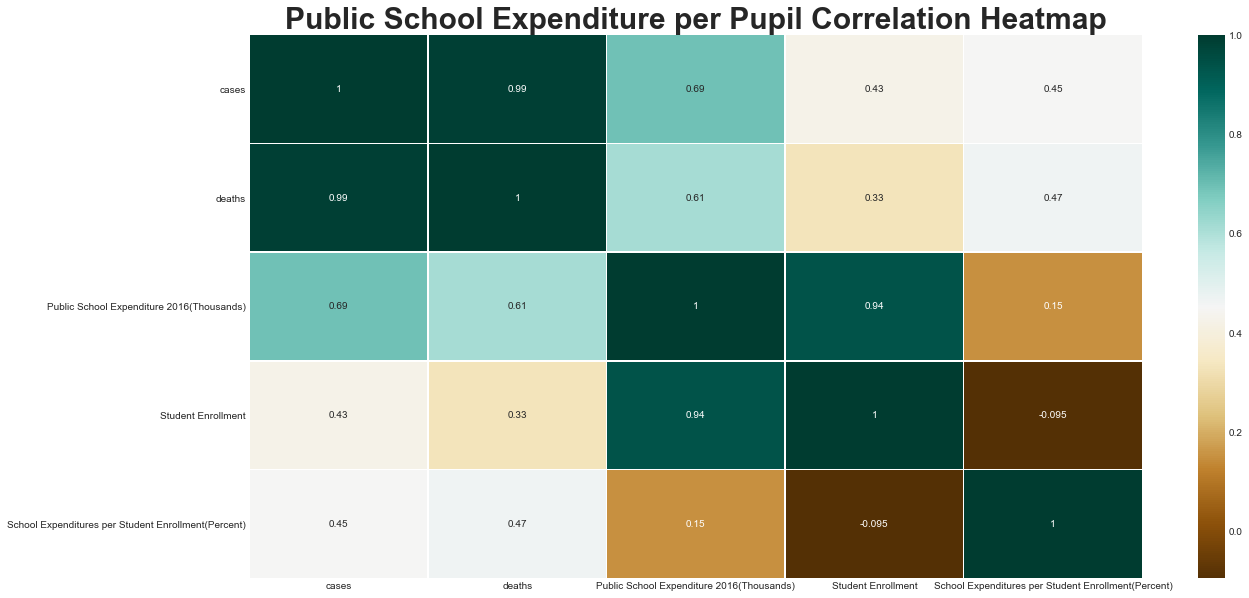

In [13]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Public School Expenditure per Pupil Correlation Heatmap', fontweight = 'bold', fontsize = 30);

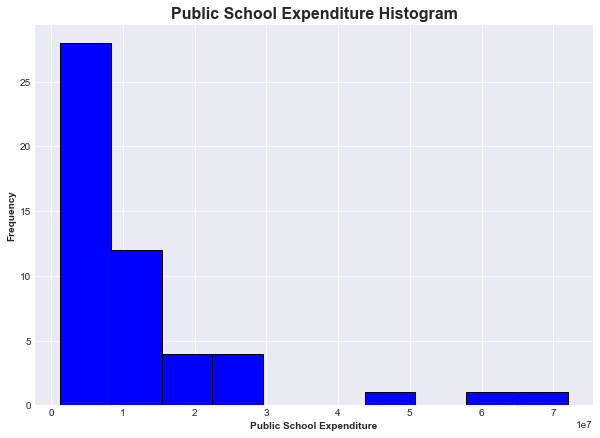

In [14]:
plt.style.use('seaborn-darkgrid')

psePupil['Public School Expenditure 2016(Thousands)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Public School Expenditure Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Public School Expenditure', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

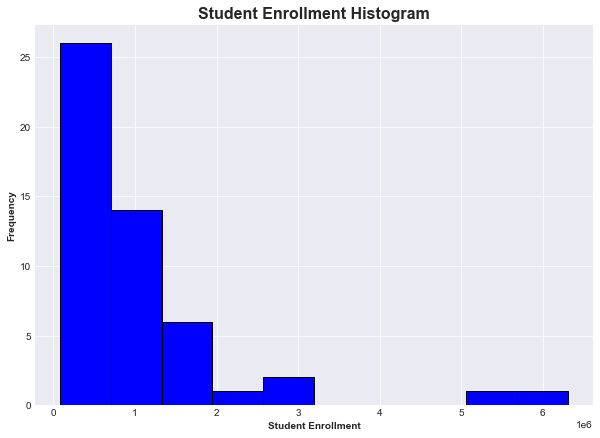

In [15]:
plt.style.use('seaborn-darkgrid')

psePupil['Student Enrollment'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Student Enrollment Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Student Enrollment', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

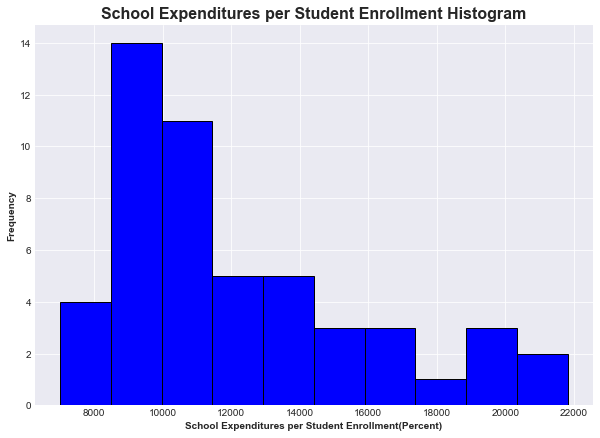

In [16]:
plt.style.use('seaborn-darkgrid')

psePupil['School Expenditures per Student Enrollment(Percent)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('School Expenditures per Student Enrollment Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('School Expenditures per Student Enrollment(Percent)', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

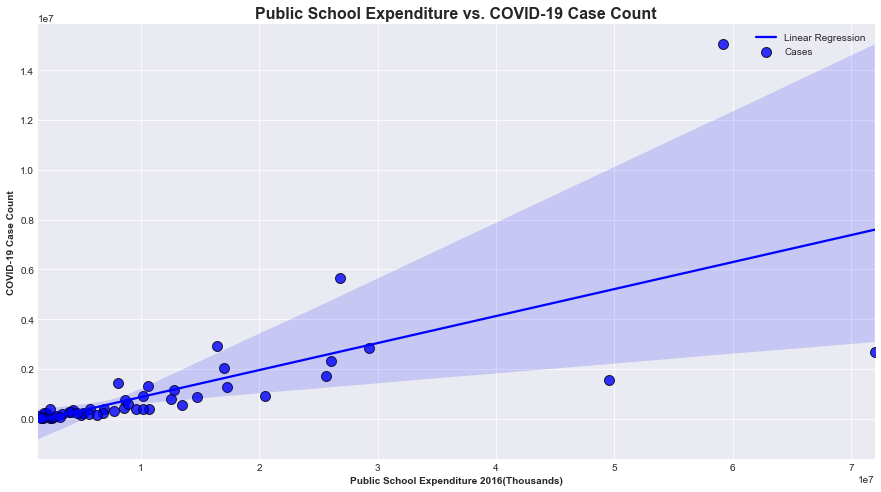

In [17]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Public School Expenditure 2016(Thousands)', y = 'cases', data = psePupil, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Public School Expenditure vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Public School Expenditure 2016(Thousands)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [18]:
model1 = sm.OLS(psePupil['cases'], psePupil['Public School Expenditure 2016(Thousands)']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.571
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              66.58
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    9.43e-11
Time:                        01:58:51   Log-Likelihood:                         -801.38
No. Observations:                  51   AIC:                                      1605.
Df Residuals:                      50   BIC:                                      1607.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Public School Expenditure 2016(Thousands)     0.1011      0.012      8.160      0.000       0.076       0.126
==============================================================================
Omnibus:                       67.299   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              905.076
Skew:                           3.183   Prob(JB):                    2.92e-197
Kurtosis:                      22.631   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

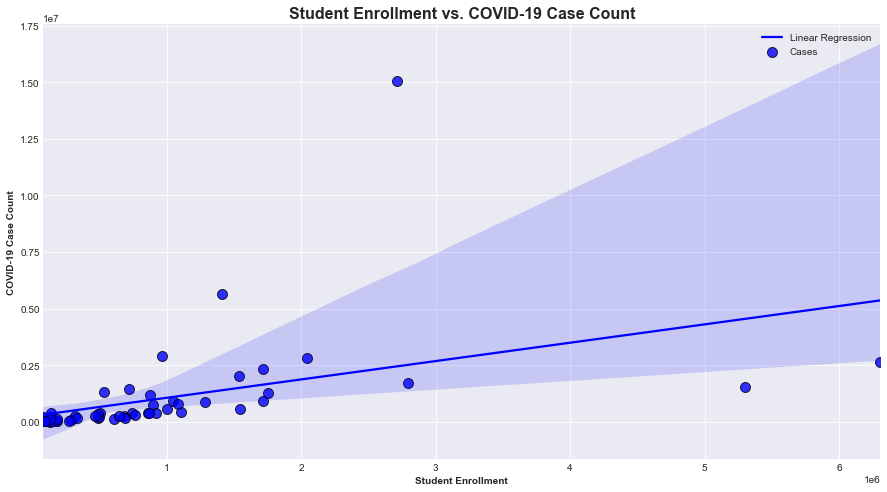

In [19]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Student Enrollment', y = 'cases', data = psePupil, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Student Enrollment vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Student Enrollment', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [20]:
model2 = sm.OLS(psePupil['cases'], psePupil['Student Enrollment']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.325
Model:                            OLS   Adj. R-squared (uncentered):              0.311
Method:                 Least Squares   F-statistic:                              24.07
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    1.03e-05
Time:                        01:58:51   Log-Likelihood:                         -812.94
No. Observations:                  51   AIC:                                      1628.
Df Residuals:                      50   BIC:                                      1630.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Student Enrollment     0.9183      0.187      4.906      0.000       0.542       1.294
==============================================================================
Omnibus:                       85.549   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1566.657
Skew:                           4.544   Prob(JB):                         0.00
Kurtosis:                      28.587   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

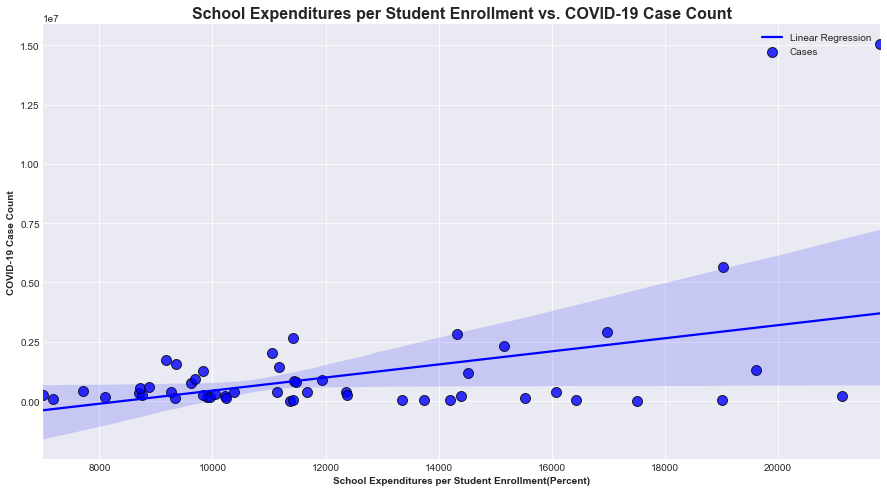

In [21]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'School Expenditures per Student Enrollment(Percent)', y = 'cases', data = psePupil, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('School Expenditures per Student Enrollment vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('School Expenditures per Student Enrollment(Percent)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [22]:
model3 = sm.OLS(psePupil['cases'], psePupil['School Expenditures per Student Enrollment(Percent)']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.277
Model:                            OLS   Adj. R-squared (uncentered):              0.263
Method:                 Least Squares   F-statistic:                              19.20
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    6.03e-05
Time:                        01:58:52   Log-Likelihood:                         -814.68
No. Observations:                  51   AIC:                                      1631.
Df Residuals:                      50   BIC:                                      1633.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
School Expenditures per Student Enrollment(Percent)   101.7781     23.225      4.382      0.000      55.128     148.428
==============================================================================
Omnibus:                       89.176   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1740.597
Skew:                           4.844   Prob(JB):                         0.00
Kurtosis:                      29.930   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

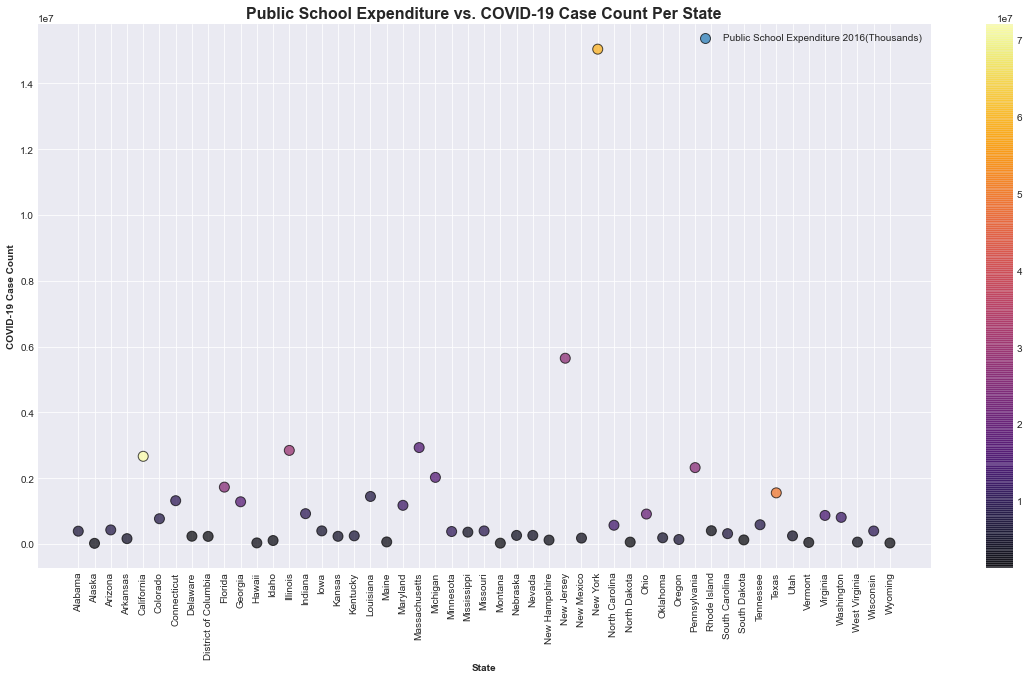

In [23]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = psePupil['State'] 
y = psePupil['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = psePupil['Public School Expenditure 2016(Thousands)'], cmap = 'inferno')
plt.title('Public School Expenditure vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Public School Expenditure 2016(Thousands)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

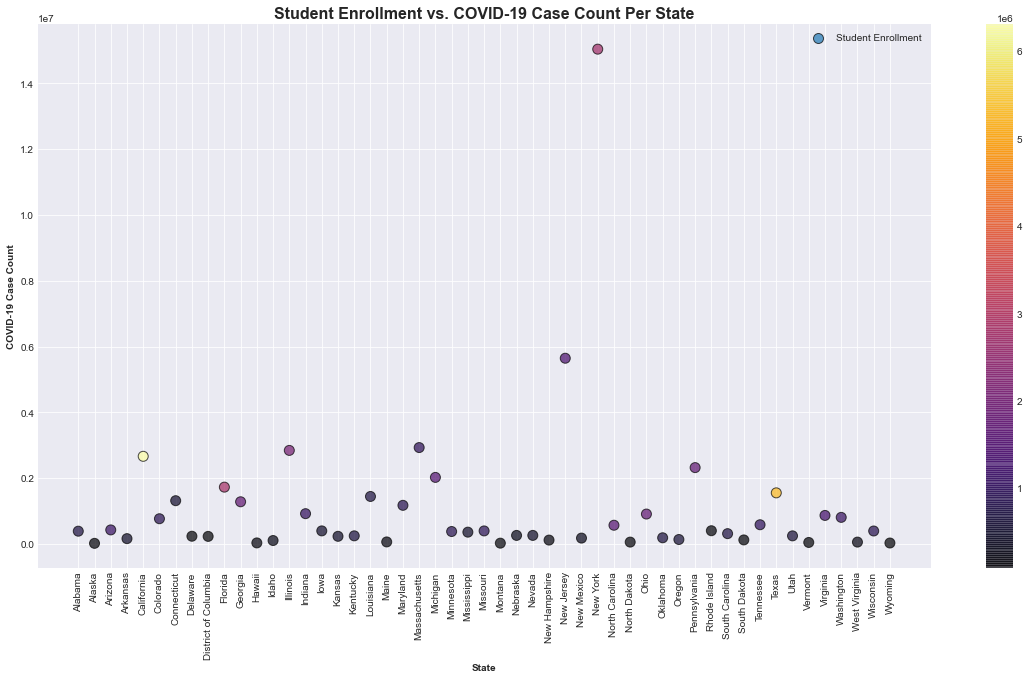

In [24]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = psePupil['State'] 
y = psePupil['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = psePupil['Student Enrollment'], cmap = 'inferno')
plt.title('Student Enrollment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Student Enrollment'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

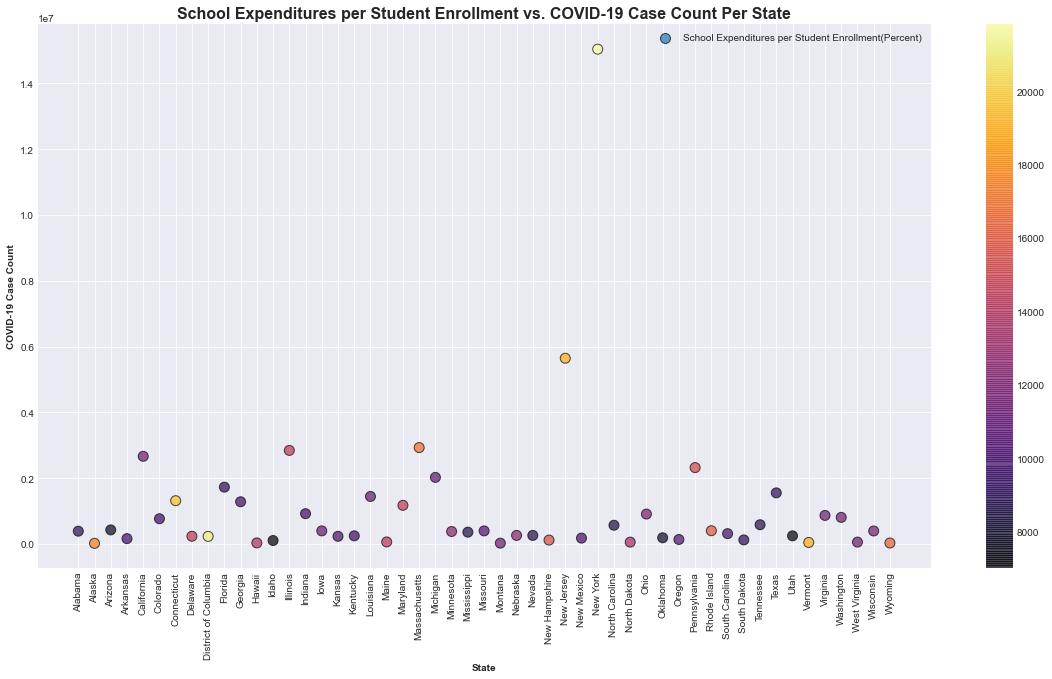

In [25]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = psePupil['State'] 
y = psePupil['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = psePupil['School Expenditures per Student Enrollment(Percent)'], cmap = 'inferno')
plt.title('School Expenditures per Student Enrollment vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['School Expenditures per Student Enrollment(Percent)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [23]:
test_len = int(0.25 * len(psePupil))
train_len = len(psePupil) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = psePupil[:train_len]
test = psePupil[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 6)
Test Set Shape: (12, 6)


In [24]:
features_list = ['Public School Expenditure 2016(Thousands)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


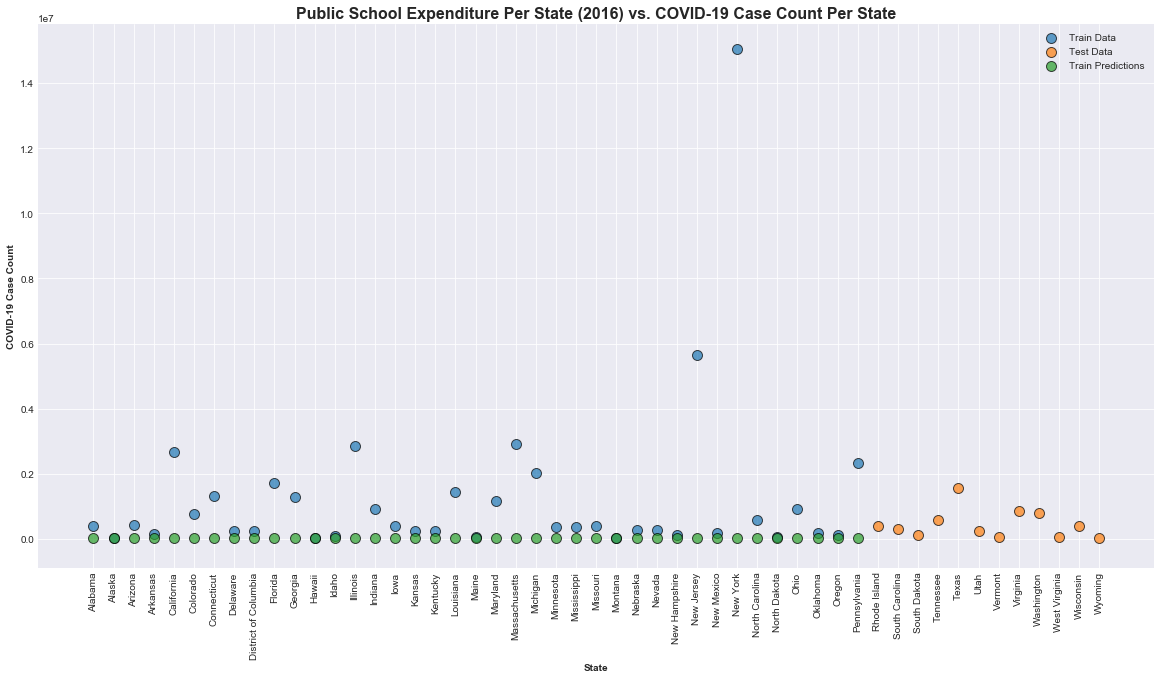

In [25]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Expenditure Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

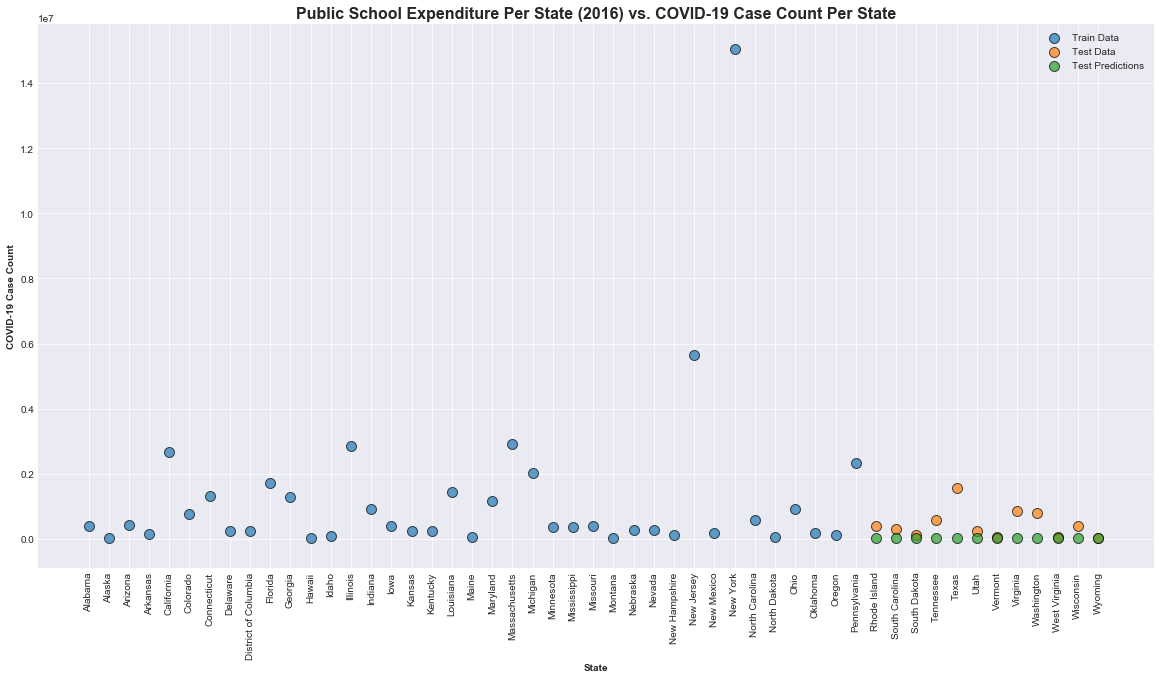

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Expenditure Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [27]:
features_list = ['Student Enrollment']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


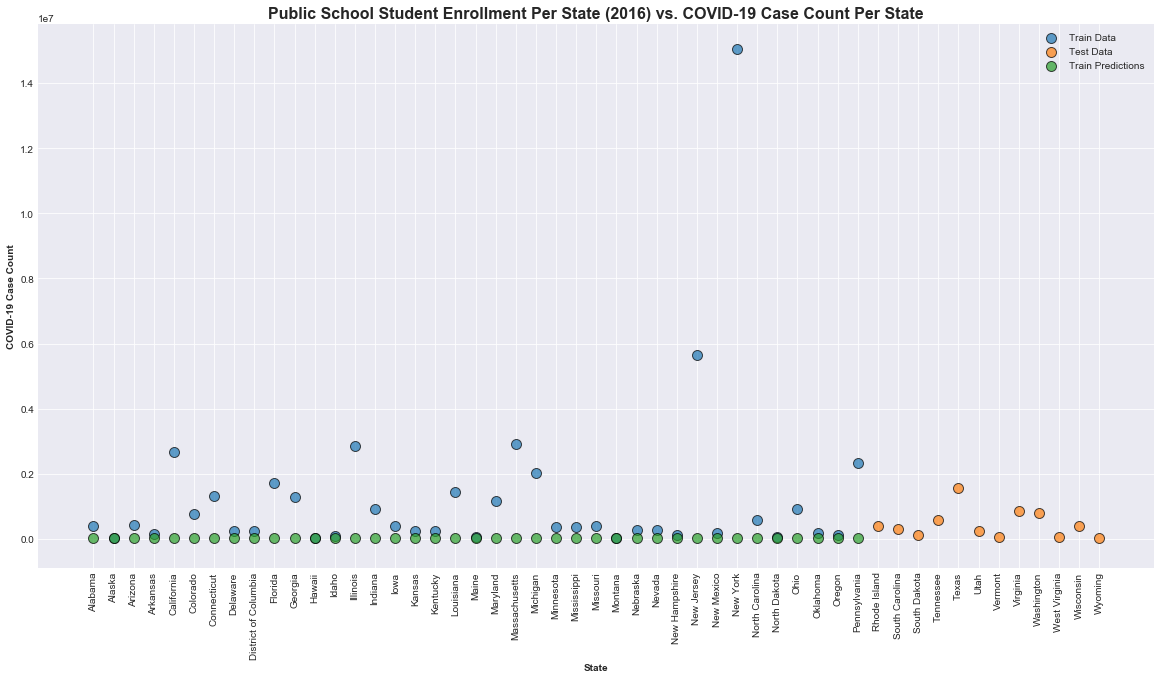

In [28]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Student Enrollment Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

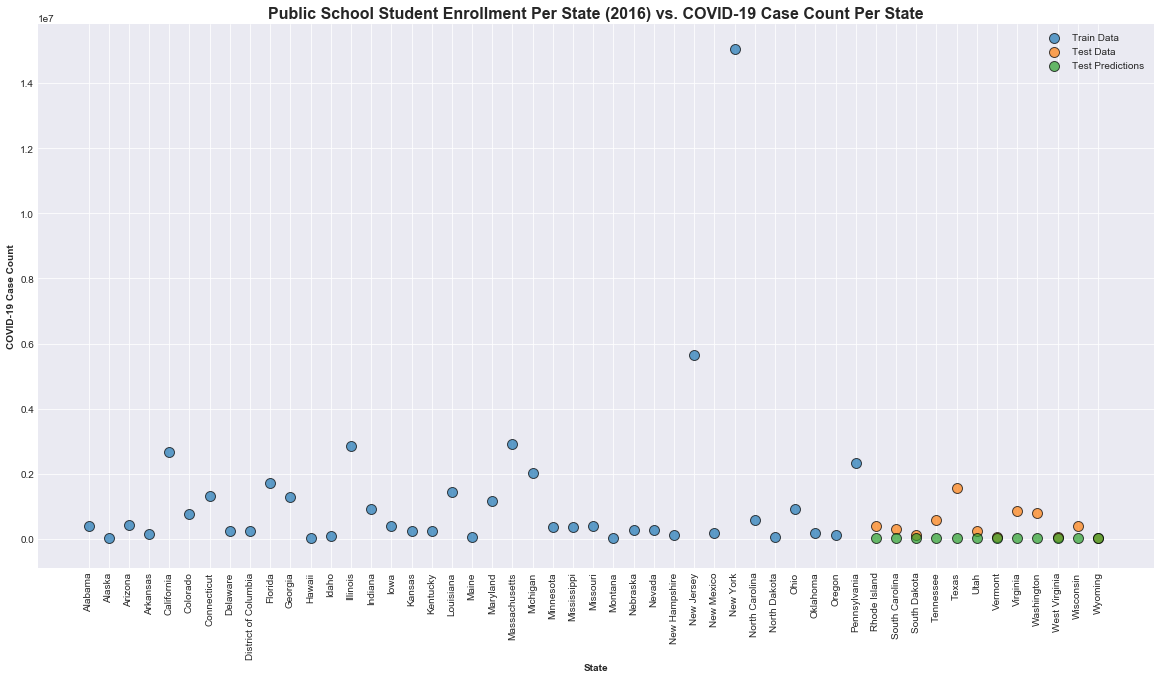

In [29]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Student Enrollment Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [30]:
features_list = ['School Expenditures per Student Enrollment(Percent)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


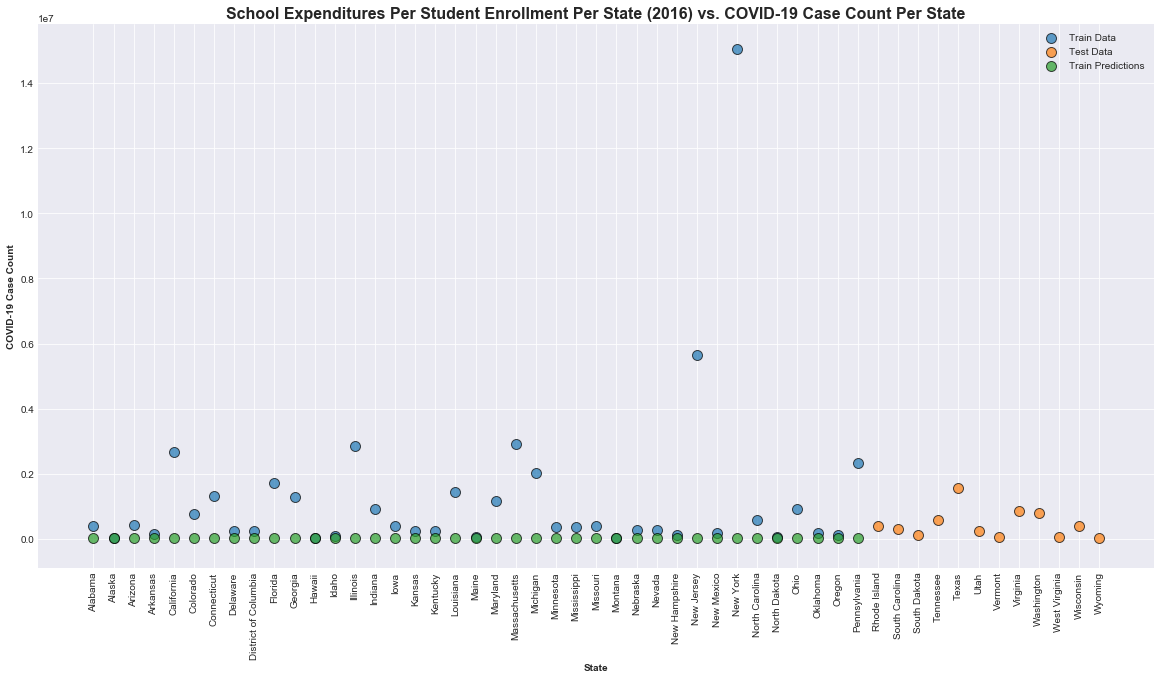

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('School Expenditures Per Student Enrollment Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

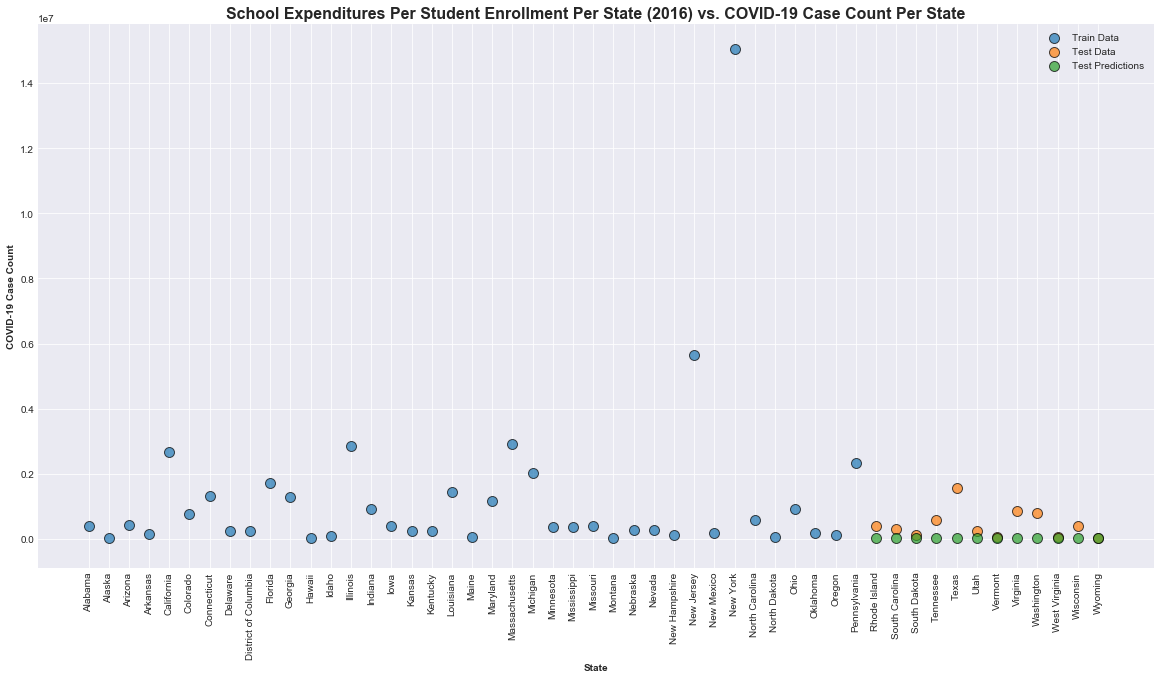

In [32]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('School Expenditures Per Student Enrollment Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [33]:
features_list = ['Public School Expenditure 2016(Thousands)','Student Enrollment']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


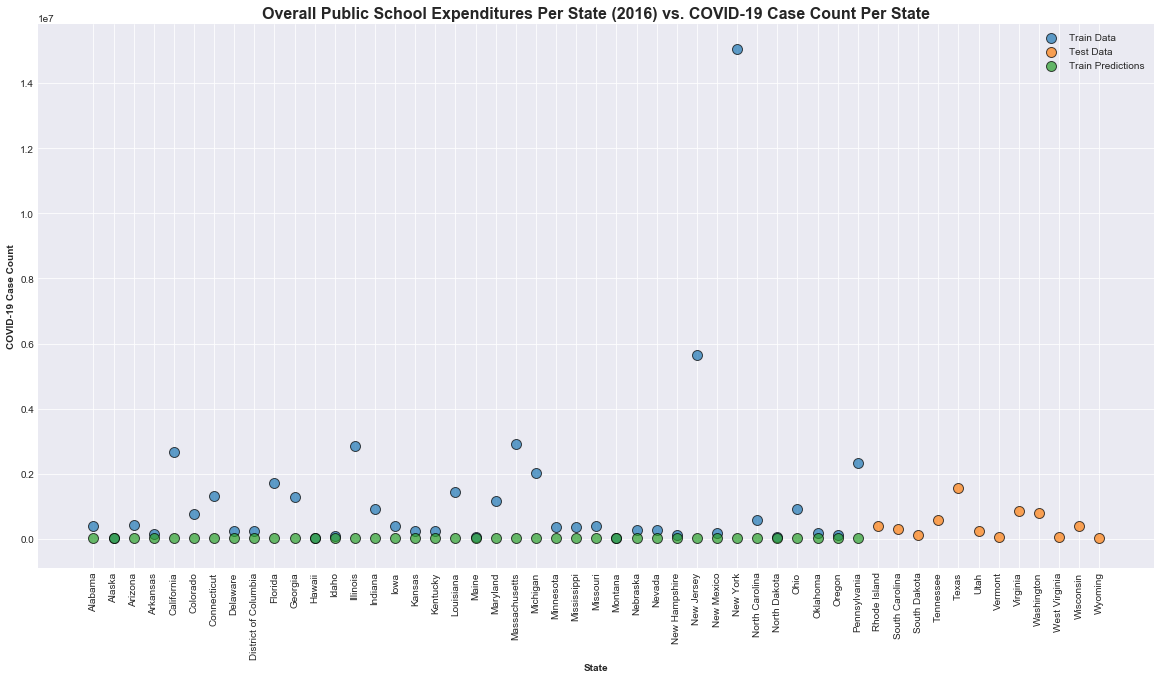

In [34]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Public School Expenditures Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

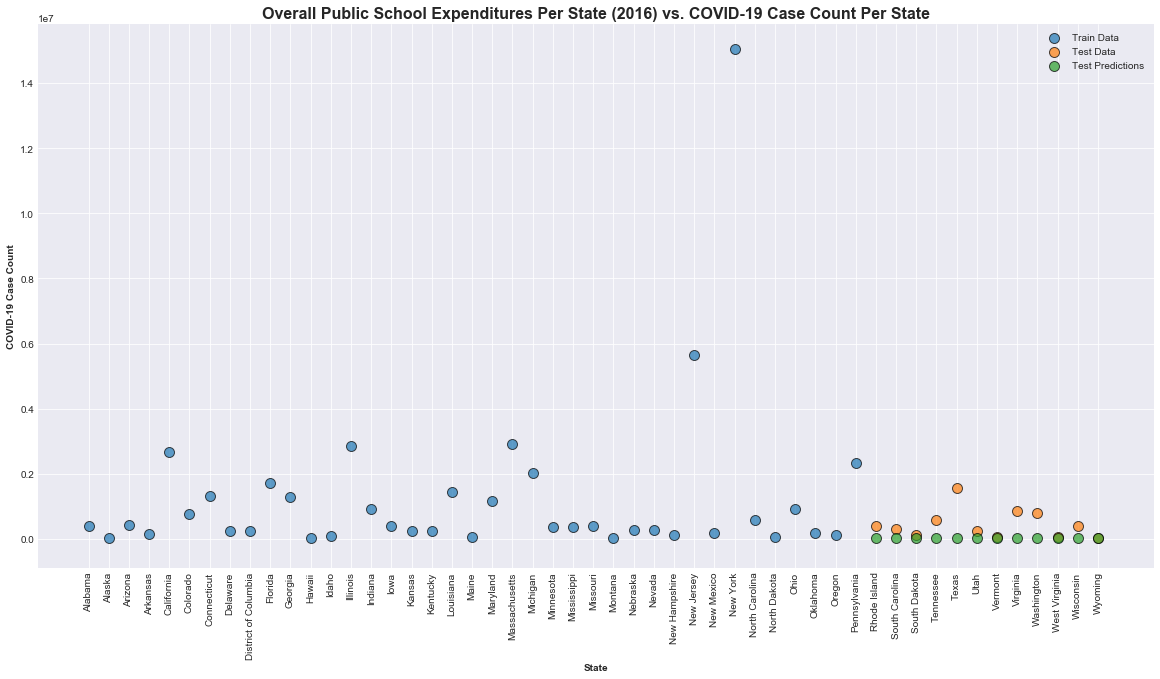

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Public School Expenditures Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();